In [1]:
# !unzip shapes.zip
# !ls

In [ ]:
# !pip install --upgrade tensorflow

In [3]:
import tensorflow as tf

shapes_data = tf.keras.utils.image_dataset_from_directory(
    'shapes',
    image_size=(150, 150),
    batch_size=32)

print(shapes_data)

Found 300 files belonging to 3 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [4]:
import numpy as np
X = []
y = []
for images, labels in shapes_data:
    X.extend(images.numpy())
    y.extend(labels.numpy())

X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.3, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(210, 150, 150, 3) (210,)
(90, 150, 150, 3) (90,)


[ 85 163  83  35 192 112 115  89   2]


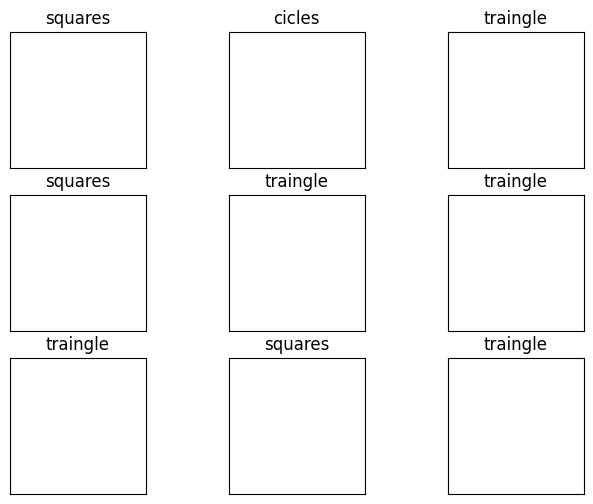

In [5]:
# 데이터 로드
import numpy as np
import matplotlib.pyplot as plt
class_names =['cicles','squares','traingle']

samples = np.random.randint(len(X_train), size = 9)
print(samples)
plt.figure(figsize = (8,6))
for i , idx in enumerate(samples):
  plt.subplot(3,3, i+1)
  plt.xticks([])
  plt.yticks([])
  tra = X_train[idx]
  plt.imshow(tra, cmap ='gray')
  plt.title(class_names[y_train[idx]])
plt.show()

### Data augmentation

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
rescale = 1./ 255, #데이터에 제공된 값을 곱함
rotation_range = 20, # 무작위 회전에 대한 도(ㅇ) 단위 범위
width_shift_range = 0.1, #이미지를 수평으로 임의로 이동(전체 너비의 대칭)
height_shift_range = 0.1, #이미지를 수직으로 임의로 이동(전체 높이의 대칭)
zoom_range = 0.05, # 무작위 확대/축소 범위
horizontal_flip = True, #입력을 수평으로 랜덤하게 뒤집음
fill_mode = 'reflect') #One of {“constant”, “nearest”, “reflect” or “wrap”}, “nearest”가 기본
val_datagen = ImageDataGenerator(rescale=1./ 255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

In [7]:
# 원핫인코딩
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)

y_train_oh[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [8]:
print(X_train.shape, y_train_oh.shape)
print(X_val.shape, y_val_oh.shape)

(210, 150, 150, 3) (210, 3)
(90, 150, 150, 3) (90, 3)


In [9]:
train_generator = train_datagen.flow(X_train, y_train_oh, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val_oh, batch_size=64)

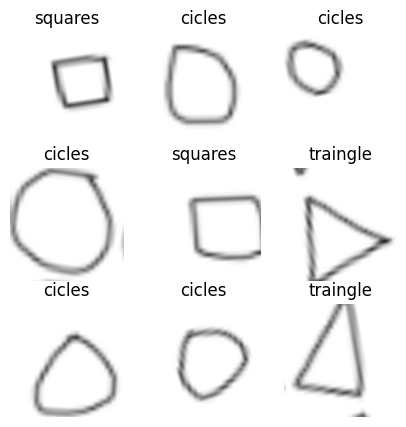

In [10]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.show()


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
drop_rate = 0.2

def build_cnn_model():
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3,3), input_shape=(150, 150, 3), padding="SAME", activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3,3), input_shape=(150, 150, 3), padding="SAME", activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(128, (3,3), input_shape=(150, 150, 3), padding="SAME", activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(drop_rate))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(drop_rate))
  model.add(layers.Dense(3, activation='softmax'))
  return model

In [19]:
# 모델 로드
model = build_cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      42,468,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,087,939 (164.37 MB)

 Trainable params: 43,087,939 (164.37 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

EPOCHS = 100
BATCH_SIZE =64
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.keras.backend.clear_session()

# 학습
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    batch_size = 64,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Num GPUs Available:  1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 0.2838 - loss: 3.6780 - val_acc: 0.3778 - val_loss: 1.1581
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - acc: 0.3474 - loss: 1.1469 - val_acc: 0.3111 - val_loss: 1.1006
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - acc: 0.3006 - loss: 1.1094 - val_acc: 0.3111 - val_loss: 1.1159
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - acc: 0.2895 - loss: 1.1092 - val_acc: 0.3111 - val_loss: 1.0989
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - acc: 0.3550 - loss: 1.0971 - val_acc: 0.3222 - val_loss: 1.0986
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - acc: 0.4053 - loss: 1.0956 - val_acc: 0.3000 - val_loss: 1.1005
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - acc: 0.3869 - loss: 1.0953 - val_acc: 0.3111 - val_loss: 1.1042
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - acc: 0.3454 - loss: 1.1023 - val_acc: 0.3111 - val_loss: 1.0967
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - acc: 0.3737 - loss: 1.0939 - val_

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize = (16,8))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'], label='Val Accuracy')
  plt.legend()

plt.show()

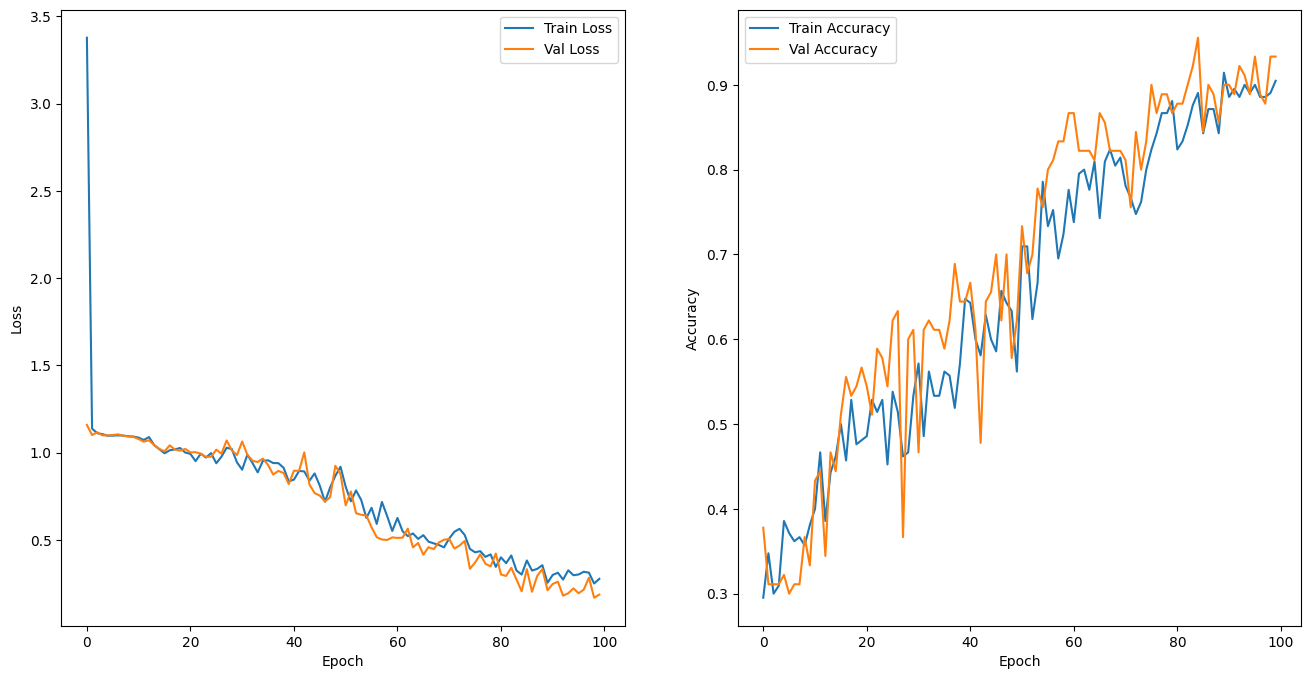

In [23]:
plot_history(history)

#10. 예측

In [26]:
y_pred = model.predict(X_val)
y_pred[:1]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


array([[0., 0., 1.]], dtype=float32)

In [27]:
loss, accuracy = model.evaluate(X_val, y_val_oh, verbose=2)
print(f"Test loss: {loss:.2f}")
print(f"Test accuracy: {accuracy:.2f}")


3/3 - 1s - 488ms/step - acc: 0.9000 - loss: 10.9179
Test loss: 10.92
Test accuracy: 0.90


In [28]:
y_pred_argmax = np.argmax(y_pred, axis = 1)
y_pred_argmax[:10]


array([2, 2, 0, 2, 2, 2, 1, 1, 0, 2])